In [4]:
import os
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dists
# import matplotlib; matplotlib.use('Agg')  # Allows to create charts with undefined $DISPLAY
import matplotlib.pyplot as plt

from model import FullyConnected, BayesianRegression
from viz import plot_1d_posterior_predictive
from util import (
    ftens_cuda,
    to_np,
    cuda_available,
    add_output_noise,
    train_objective,
)

%matplotlib inline

def get_coverage_bounds(posterior_pred_samples, percentile):
    '''
    Assumes N x samples
    '''
    assert(not (percentile < 0. or percentile > 100.))

    lower_percentile = (100.0 - percentile) / 2.0
    upper_percentile = 100.0 - lower_percentile

    upper_bounds = np.percentile(posterior_pred_samples, upper_percentile, axis=-1)
    lower_bounds = np.percentile(posterior_pred_samples, lower_percentile, axis=-1)

    return lower_bounds, upper_bounds

def plot_1d_posterior_predictive(x_train, y_train, x_viz, y_pred):
    assert(len(x_train.shape) == 2 and x_train.shape[-1] == 1)
    assert(len(y_train.shape) == 2 and y_train.shape[-1] == 1)
    assert(len(x_viz.shape) == 2 and x_viz.shape[-1] == 1)    
    assert(len(y_pred.shape) == 2 and y_pred.shape[0] == x_viz.shape[0])

    # make sure x_viz is sorted in ascending order
    x_viz = to_np(x_viz.squeeze())
    assert(np.all(x_viz[:-1] <= x_viz[1:]))
        
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # plot predictive intervals
    for picp, alpha in zip([50.0, 68.0, 95.0], [0.4, 0.3, 0.2]):
        lower, upper = get_coverage_bounds(to_np(y_pred), picp)
        ax.fill_between(
            x_viz, lower, upper, label='{}%-PICP'.format(picp), color='steelblue', alpha=alpha,
        )

    # plot predictive mean
    pred_mean = to_np(torch.mean(y_pred, -1))        
    ax.plot(x_viz, pred_mean, color='blue', lw=3, label='Predictive Mean')

    # plot training data
    ax.scatter(x_train, y_train, color='red', s=10.0, zorder=10, label='Training Data')

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')    
    ax.set_title('Posterior Predictive')
    ax.legend()
    
    plt.show()
        
# define model
w_prior_var = 1.0 # variance of prior over weights
output_var = 0.01 # variance of observation noise
model = BayesianRegression(w_prior_var, output_var)

# set training data
N = 50
# x_train = dists.Uniform(-1.0, -0.5).sample((N/2, 1))
x_train = torch.cat((dists.Uniform(-1.0, -0.5).sample((N//2, 1)), dists.Uniform(0.5, 1).sample((N//2, 1))))
y_train = add_output_noise(torch.pow(x_train, 3.0), output_var)

Epoch 0: loss = 67.9368180954639
Final Loss = 0.008956742715777101


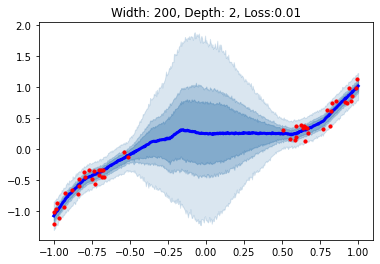

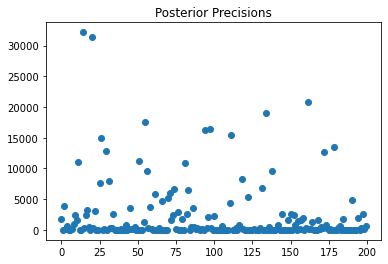

Text(0.5, 1.0, 'Posterior precision vs mean')

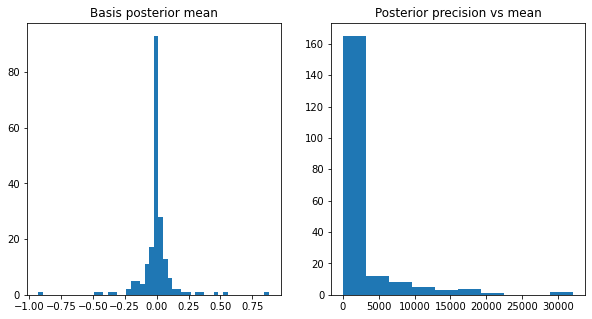

In [8]:
LEARNING_RATE = 0.001 
EPOCHS = 5000
ACTIVATION = nn.LeakyReLU
n_bases = 200
w_prior_var = np.sqrt(1/n_bases) # variance of prior over weights
w_prior_var = 1.0

fig, ax = plt.subplots(1, 1)

layers = [1, 20, n_bases, 1]
# define a neural network feature basis and final layer
basis = FullyConnected(layers[:-1], activation_module=ACTIVATION, output_activation=True)
final_layer = FullyConnected(layers[-2:], activation_module=ACTIVATION)

# define MLE loss
def mle_loss():
    y_pred = final_layer(basis(x_train))
    loss = torch.mean(torch.sum(torch.pow(final_layer(basis(x_train)) - y_train, 2.0), -1))
    return loss, (basis, final_layer)

basis.rand_init(math.sqrt(w_prior_var))
final_layer.rand_init(math.sqrt(w_prior_var))

# optimize loss to learn network
(basis, final_layer), loss = train_objective(
    list(basis.parameters()) + list(final_layer.parameters()),
    mle_loss,
    lr=LEARNING_RATE,
    print_freq=10000,
    l2=0.1,
    epochs=EPOCHS
)

model.infer_posterior(basis(x_train), y_train)

# sample from posterior predictive
x_viz = ftens_cuda(np.linspace(-1.0, 1.0, 500)).unsqueeze(-1)
y_pred = model.sample_posterior_predictive(basis(x_viz), 500)

# visualize posterior predictive
x_viz = to_np(x_viz.squeeze())

# plot predictive intervals
for picp, alpha in zip([50.0, 68.0, 95.0], [0.4, 0.3, 0.2]):
    lower, upper = get_coverage_bounds(to_np(y_pred), picp)
    ax.fill_between(
        x_viz, lower, upper, label='{}%-PICP'.format(picp), color='steelblue', alpha=alpha,
    )

# plot predictive mean
pred_mean = to_np(torch.mean(y_pred, -1))        
ax.plot(x_viz, pred_mean, color='blue', lw=3, label='Predictive Mean')

# plot training data
ax.scatter(x_train, y_train, color='red', s=10.0, zorder=10, label='Training Data')

ax.set_title('Width: {}, Depth: {}, Loss:{:.2f}'.format(layers[-2], len(layers)-2, loss))
# ax.legend()
plt.show()
num_bases = layers[-2]
plt.plot(np.arange(0, num_bases), np.diag(model.posterior.precision_matrix.detach())[:-1], 'o')
plt.title('Posterior Precisions')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].hist(model.posterior.loc.detach().numpy()[:-1], bins=50)
ax[0].set_title('Basis posterior mean')

ax[1].hist(np.diag(model.posterior.precision_matrix.detach())[:-1])
ax[1].set_title('Posterior precision vs mean')

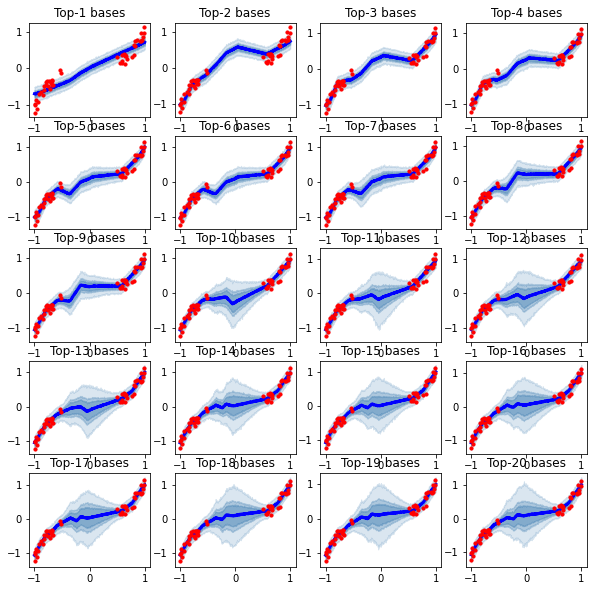

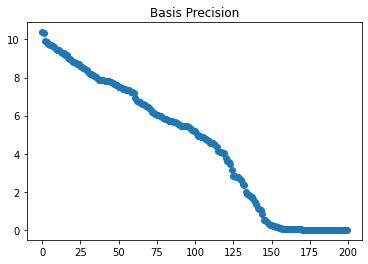

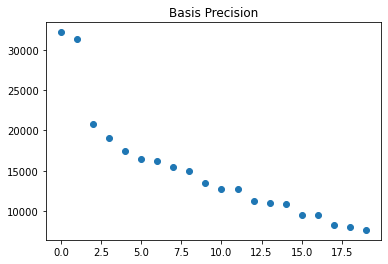

In [9]:
nrows = 5
fig, axs = plt.subplots(nrows,(20-1)//nrows + 1, figsize=(10, 10))
axs = axs.flatten()

for k in range(1,21):
    ax = axs[k-1]
    topk=torch.diag(model.posterior.precision_matrix)[:-1].topk(k)[1]
    phi_topk = basis(x_train)[:, topk]
    model_topk = BayesianRegression(w_prior_var, output_var)
    model_topk.infer_posterior(phi_topk, y_train)

    x_viz = ftens_cuda(np.linspace(-1.0, 1.0, 500)).unsqueeze(-1)
    y_pred = model_topk.sample_posterior_predictive(basis(x_viz)[:,topk], 500)
    x_viz = to_np(x_viz.squeeze())

    for picp, alpha in zip([50.0, 68.0, 95.0], [0.4, 0.3, 0.2]):
        lower, upper = get_coverage_bounds(to_np(y_pred), picp)
        ax.fill_between(
            x_viz, lower, upper, label='{}%-PICP'.format(picp), color='steelblue', alpha=alpha,
        )

    # plot predictive mean
    pred_mean = to_np(torch.mean(y_pred, -1))        
    ax.plot(x_viz, pred_mean, color='blue', lw=3, label='Predictive Mean')
    ax.set_title('Top-{k} bases'.format(k=k))

    ax.scatter(x_train, y_train, color='red', s=10.0, zorder=10, label='Training Data')

plt.show()

plt.plot(np.log(-np.sort(-np.diag(model.posterior.precision_matrix.detach())[:-1])), 'o')
# plt.plot(-np.sort(-np.diag(model.posterior.precision_matrix.detach())[:-1])[:20], 'o', c='red')
plt.title('Basis Precision')
plt.show()

plt.plot(-np.sort(-np.diag(model_topk.posterior.precision_matrix.detach())[:-1]), 'o')
plt.title('Basis Precision')
plt.show()


# plt.scatter(-np.sort(-np.diag(model_topk.posterior.precision_matrix.detach())[:-1]), -np.sort(-np.diag(model.posterior.precision_matrix.detach())[:-1])[:20])

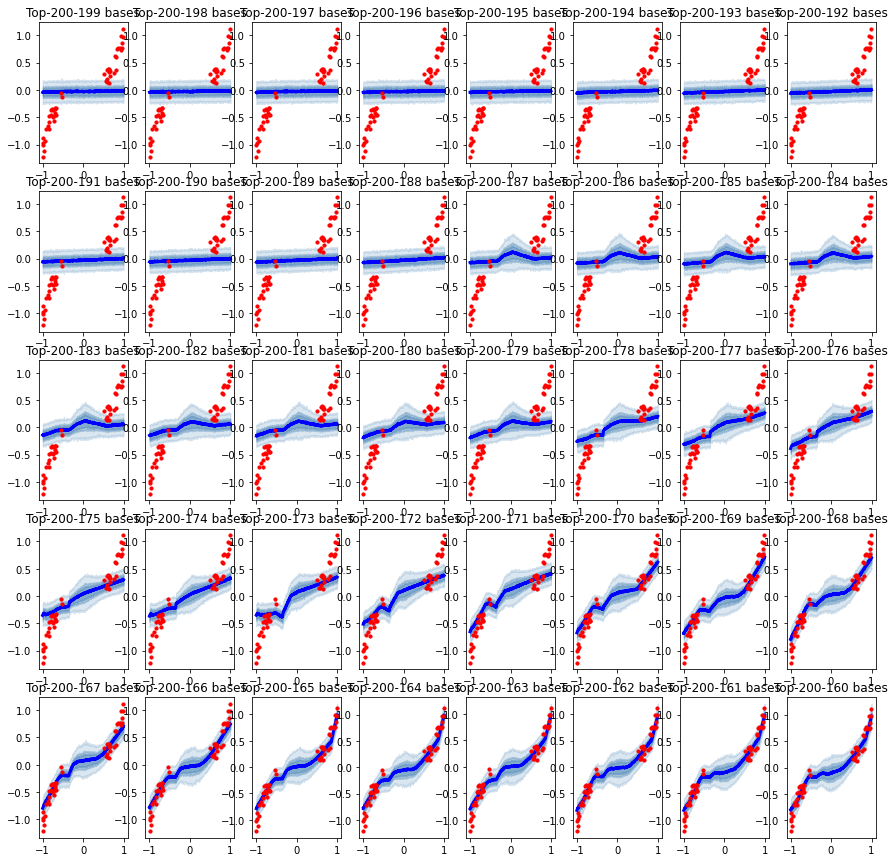

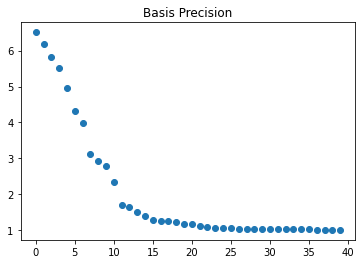

In [28]:
nrows = 5
fig, axs = plt.subplots(nrows,(40-1)//nrows + 1, figsize=(15, 15))
axs = axs.flatten()

basis_vals, basis_index = torch.diag(model.posterior.precision_matrix)[:-1].topk(num_bases)
basis_index = basis_index[basis_vals > 1.01]

for k in range(1,41):
    ax = axs[k-1]
    # topk = torch.cat([basis_index[1:10], basis_index[-1-k:-1]])
    topk = basis_index[-1-k:-1]
    
    phi_topk = basis(x_train)[:, topk]
    model_topk = BayesianRegression(w_prior_var, output_var)
    model_topk.infer_posterior(phi_topk, y_train)

    x_viz = ftens_cuda(np.linspace(-1.0, 1.0, 500)).unsqueeze(-1)
    y_pred = model_topk.sample_posterior_predictive(basis(x_viz)[:,topk], 500)
    x_viz = to_np(x_viz.squeeze())

    for picp, alpha in zip([50.0, 68.0, 95.0], [0.4, 0.3, 0.2]):
        lower, upper = get_coverage_bounds(to_np(y_pred), picp)
        ax.fill_between(
            x_viz, lower, upper, label='{}%-PICP'.format(picp), color='steelblue', alpha=alpha,
        )

    # plot predictive mean
    pred_mean = to_np(torch.mean(y_pred, -1))        
    ax.plot(x_viz, pred_mean, color='blue', lw=3, label='Predictive Mean')
    ax.set_title(f'Top-{num_bases}-{num_bases - k} bases')

    ax.scatter(x_train, y_train, color='red', s=10.0, zorder=10, label='Training Data')

plt.show()

# plt.plot(-np.sort(-np.diag(model.posterior.precision_matrix.detach())[:-1]), 'o')
# plt.plot(-np.sort(-np.diag(model.posterior.precision_matrix.detach())[:-1])[:20], 'o', c='red')
# plt.title('Basis Precision')
# plt.show()

plt.plot(-np.sort(-np.diag(model_topk.posterior.precision_matrix.detach())[:-1]), 'o')
plt.title('Basis Precision')
plt.show()

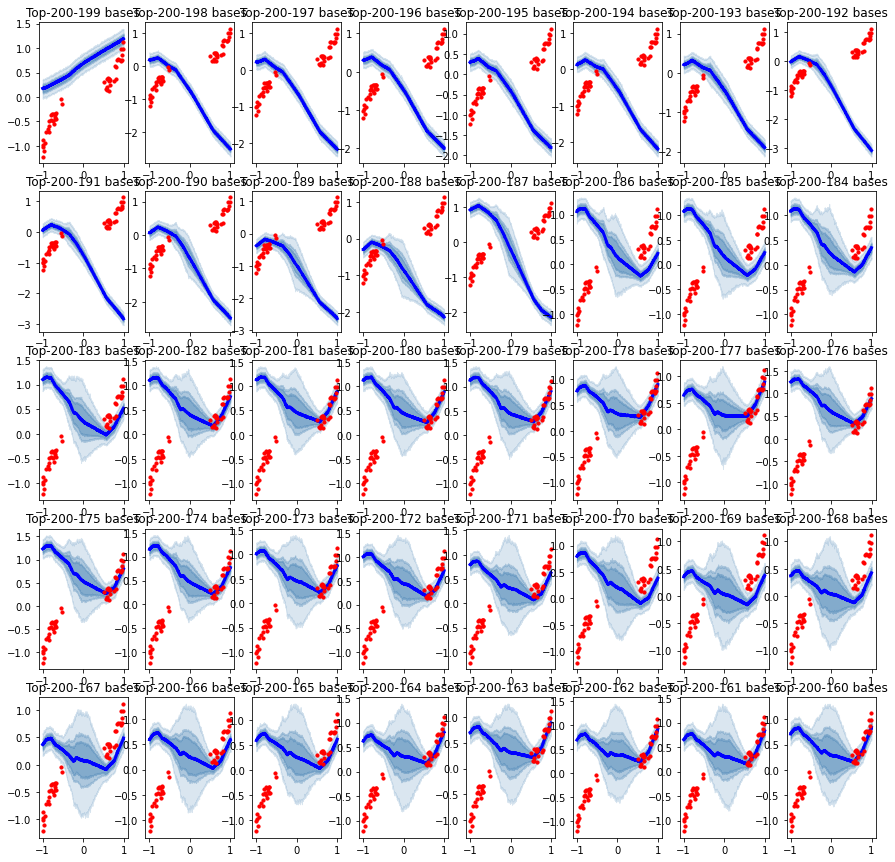

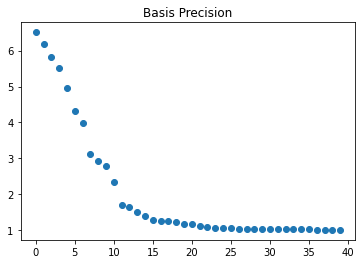

In [60]:
nrows = 5
fig, axs = plt.subplots(nrows,(40-1)//nrows + 1, figsize=(15, 15))
axs = axs.flatten()

basis_vals, basis_index = torch.diag(model.posterior.precision_matrix)[:-1].topk(num_bases)
basis_index = basis_index[basis_vals > 1.01]

for k in range(1,41):
    ax = axs[k-1]
    # topk = torch.cat([basis_index[1:10], basis_index[-1-k:-1]])
    x_viz = ftens_cuda(np.linspace(-1.0, 1.0, 500)).unsqueeze(-1)

    topk = basis_index[:k]
    phi_topk = basis(x_viz)[:, topk]
    reduced_model = dists.MultivariateNormal(model.posterior.loc[topk], precision_matrix=model.posterior.precision_matrix[topk][:,topk])
    weights = reduced_model.rsample([500])
    y_pred = add_output_noise(torch.mm(phi_topk, weights.t()), 0.01)
    
    


    
    # y_pred = model.sample_posterior_predictive(basis(x_viz)[:,topk], 500)
    x_viz = to_np(x_viz.squeeze())


    for picp, alpha in zip([50.0, 68.0, 95.0], [0.4, 0.3, 0.2]):
        lower, upper = get_coverage_bounds(to_np(y_pred), picp)
        ax.fill_between(
            x_viz, lower, upper, label='{}%-PICP'.format(picp), color='steelblue', alpha=alpha,
        )

    # plot predictive mean
    pred_mean = to_np(torch.mean(y_pred, -1))        
    ax.plot(x_viz, pred_mean, color='blue', lw=3, label='Predictive Mean')
    ax.set_title(f'Top-{num_bases}-{num_bases - k} bases')

    ax.scatter(x_train, y_train, color='red', s=10.0, zorder=10, label='Training Data')

plt.show()

# plt.plot(-np.sort(-np.diag(model.posterior.precision_matrix.detach())[:-1]), 'o')
# plt.plot(-np.sort(-np.diag(model.posterior.precision_matrix.detach())[:-1])[:20], 'o', c='red')
# plt.title('Basis Precision')
# plt.show()

plt.plot(-np.sort(-np.diag(model_topk.posterior.precision_matrix.detach())[:-1]), 'o')
plt.title('Basis Precision')
plt.show()

In [52]:
y_pred.shape

torch.Size([50, 500])

In [46]:
reduced_model = dists.MultivariateNormal(model.posterior.loc[topk], model.posterior.precision_matrix[topk][:,topk])
weights = reduced_model.rsample([100])
r = torch.mm(phi_topk, weights.t())

In [53]:
y_pred = model.sample_posterior_predictive(basis(x_viz)[:,topk], 500)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray